In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

In [2]:
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# Load data

In [60]:
df = pd.read_csv("../../data/adult.data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [61]:
len(df)

32561

In [62]:
df.columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "superior"
]

In [63]:
df = df.drop("native_country", axis=1)
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,superior
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,<=50K


In [64]:
df["superior"].value_counts() 

 <=50K    24720
 >50K      7841
Name: superior, dtype: int64

In [65]:
df["superior"] = df["superior"].apply(lambda x: "<=50K" if x == " <=50K." or x== " <=50K" else ">50K")

In [66]:
df["superior"].value_counts() 

<=50K    24720
>50K      7841
Name: superior, dtype: int64

In [67]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
superior          object
dtype: object

In [68]:
df["superior"] = df["superior"].apply(lambda x: 0 if x == "<=50K" else 1)

In [69]:
df["superior"].value_counts() 

0    24720
1     7841
Name: superior, dtype: int64

In [70]:
sample_df = df.groupby('superior').apply(lambda x: x.sample(n=5000)).reset_index(drop = True)

In [71]:
df_used = pd.get_dummies(sample_df)

In [72]:
df_used.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,superior,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,24,117167,10,0,0,53,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,40,190621,10,0,0,55,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,49,176684,11,0,0,40,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
3,26,202203,13,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,31,332379,10,0,0,50,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


In [73]:
scale = StandardScaler()
columns = df_used.columns
y = df_used["superior"].copy()
df_used = pd.DataFrame(scale.fit_transform(df_used))
df_used.columns = columns
df_used["superior"] = y.copy()
df_used.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,superior,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,-1.269824,-0.684823,-0.234729,-0.196581,-0.257642,0.911891,0,-0.209123,-0.190445,-0.269047,...,-0.341971,-0.292675,-0.264747,-0.094224,-0.188463,-0.293278,-0.085754,0.385872,1.630228,-1.630228
1,-0.036117,0.015943,-0.234729,-0.196581,-0.257642,1.077760,0,-0.209123,-0.190445,-0.269047,...,-0.341971,-0.292675,-0.264747,-0.094224,-0.188463,3.409731,-0.085754,-2.591534,1.630228,-1.630228
2,0.657844,-0.117019,0.149380,-0.196581,-0.257642,-0.166259,0,-0.209123,-0.190445,-0.269047,...,-0.341971,3.416763,-0.264747,-0.094224,-0.188463,-0.293278,-0.085754,0.385872,1.630228,-1.630228
3,-1.115611,0.126437,0.917597,-0.196581,-0.257642,0.663087,0,-0.209123,-0.190445,-0.269047,...,-0.341971,-0.292675,-0.264747,-0.094224,-0.188463,-0.293278,-0.085754,0.385872,1.630228,-1.630228
4,-0.730077,1.368342,-0.234729,-0.196581,-0.257642,0.663087,0,-0.209123,-0.190445,-0.269047,...,-0.341971,3.416763,-0.264747,-0.094224,-0.188463,-0.293278,-0.085754,0.385872,-0.613411,0.613411


In [74]:
df_used["superior"].value_counts()

0    5000
1    5000
Name: superior, dtype: int64

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(df_used.drop("superior", axis=1), df_used["superior"], train_size=0.02) 

In [76]:
X_train, X_calib, Y_train, Y_calib = train_test_split(X_train, Y_train, train_size=0.8) 

In [77]:
Y_test.value_counts()

1    4913
0    4887
Name: superior, dtype: int64

In [78]:
Y_train.value_counts()

0    91
1    69
Name: superior, dtype: int64

In [79]:
Y_calib.value_counts()

0    22
1    18
Name: superior, dtype: int64

In [80]:
logistic = LogisticRegression(max_iter=1, verbose=1, random_state=3)
logistic.fit(X_train, Y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           67     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10904D+02    |proj g|=  4.17904D+01


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(max_iter=1, random_state=3, verbose=1)


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   67      1      2      1     0     0   1.390D+01   6.781D+01
  F =   67.809104040874502     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [81]:
predictions = logistic.predict(X_test)
probas = logistic.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(predictions, Y_test)

In [82]:
accuracy

0.7896938775510204

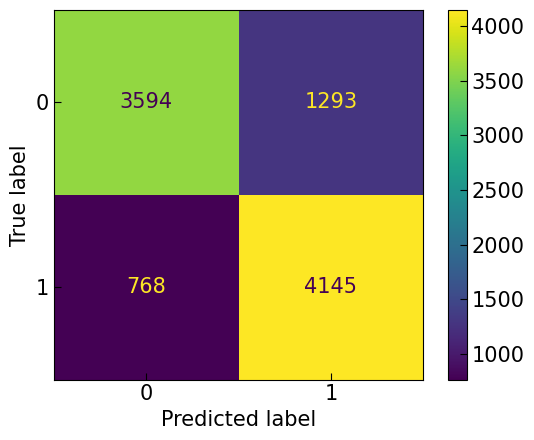

In [83]:
disp = ConfusionMatrixDisplay.from_estimator(
        logistic,
        X_test,
        Y_test,
)
plt.show()

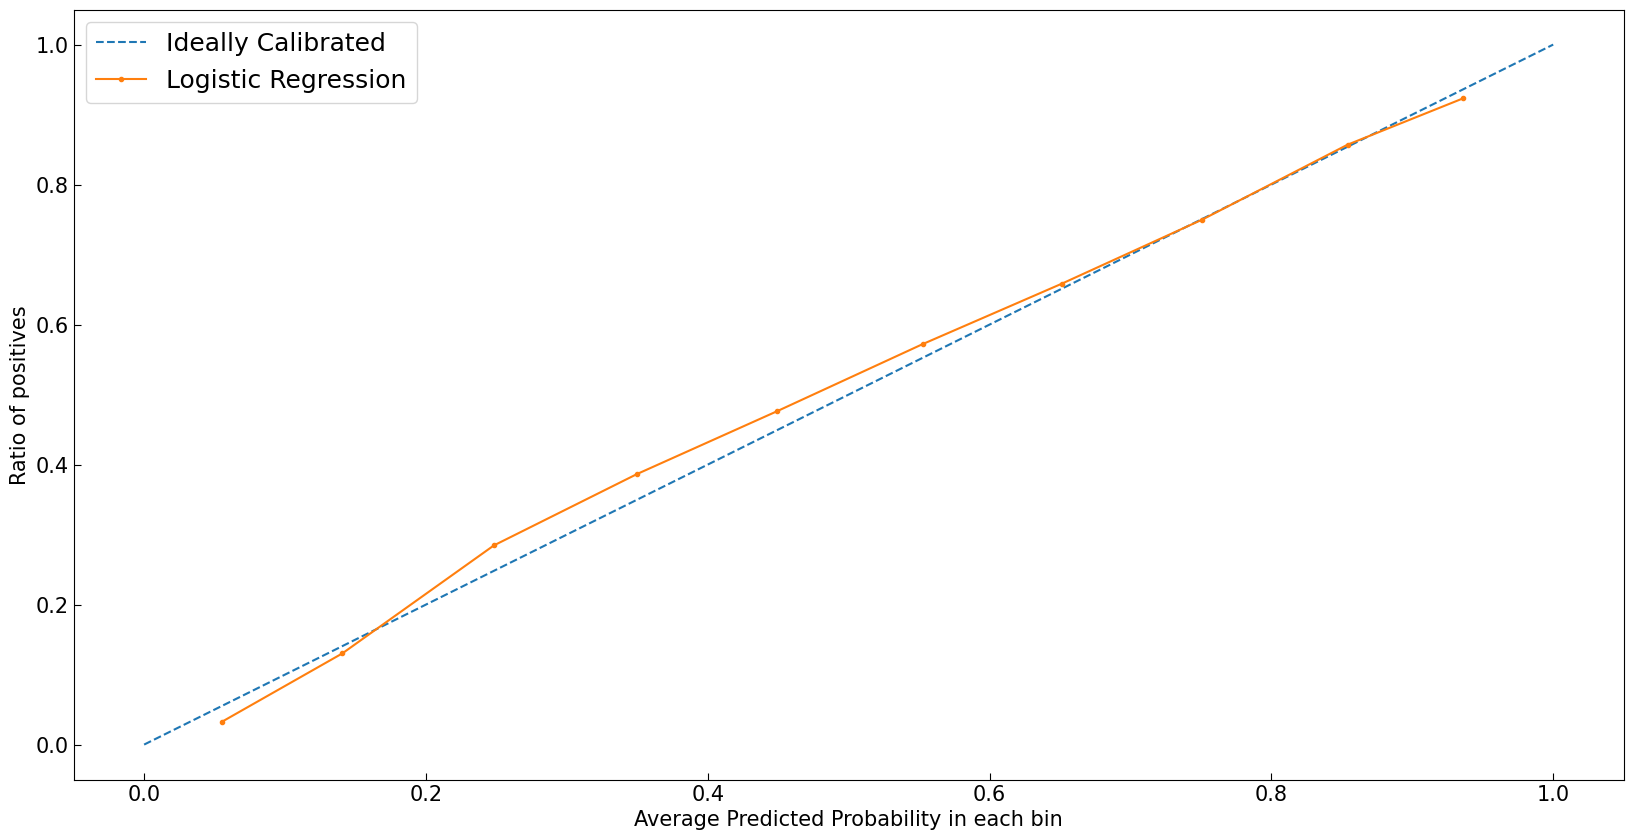

In [84]:
plt.figure(figsize=(20, 10))
prob_true, prob_pred = calibration_curve(Y_test.values, probas, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve

plt.plot(prob_pred, prob_true, marker = '.', label = 'Logistic Regression')
 

leg = plt.legend(loc = 'upper left')

plt.xlabel('Average Predicted Probability in each bin')

plt.ylabel('Ratio of positives')
plt.show()

In [85]:
def venn_abers(trained_classifier, calibration_features, test_instance, calibration_labels):
    if type(test_instance) == pd.Series:
        test_instance = pd.DataFrame(test_instance).T
    calibrations = trained_classifier.predict_proba(calibration_features)
    predictions = trained_classifier.predict_proba(test_instance)
    interval = []
    scores = pd.DataFrame()
    scores["s"] = calibrations[:, 1]
    scores["y"] = calibration_labels.to_numpy()
    score = pd.DataFrame()
    score["s"] = predictions[:, 1]
    interval = []
    for i in [0, 1]:
        score["y"] = i
        train = pd.concat([scores, score], ignore_index=True)
        g = IsotonicRegression()
        g_scores = g.fit_transform(train["s"], train["y"])
        interval.append(np.round(g.predict(score["s"])[0], 3))
    return interval

In [86]:
venn_abers(logistic, X_calib, X_test[:1], Y_calib)

[0.25, 0.5]

In [87]:
X_test_after = X_test.copy()
X_test_after["interval"] = X_test_after.apply(lambda x: venn_abers(logistic, X_calib, x, Y_calib), axis=1)
X_test_after["proba"] = logistic.predict_proba(X_test)[:, 1]
X_test_after["Y"] = Y_test.copy()
dff = X_test_after[["Y", "interval", "proba"]].copy()

In [88]:
dff.head()

,Y,interval,proba
9111,1,"[0.25, 0.5]",0.222796
532,0,"[0.4, 0.6]",0.544720
6613,1,"[0.556, 0.667]",0.716923
5504,1,"[0.556, 1.0]",0.751763
2639,0,"[0.556, 1.0]",0.783032


In [89]:
dff["inf_prob"] = dff["interval"].apply(lambda x: x[0])
dff["sup_prob"] = dff["interval"].apply(lambda x: x[1])
dff["genuine"] = dff.apply(lambda x: x["sup_prob"]/(1-x["inf_prob"]+x["sup_prob"]), axis=1)
dff.head()

,Y,interval,proba,inf_prob,sup_prob,genuine
9111,1,"[0.25, 0.5]",0.222796,0.250,0.500,0.400000
532,0,"[0.4, 0.6]",0.544720,0.400,0.600,0.500000
6613,1,"[0.556, 0.667]",0.716923,0.556,0.667,0.600360
5504,1,"[0.556, 1.0]",0.751763,0.556,1.000,0.692521
2639,0,"[0.556, 1.0]",0.783032,0.556,1.000,0.692521


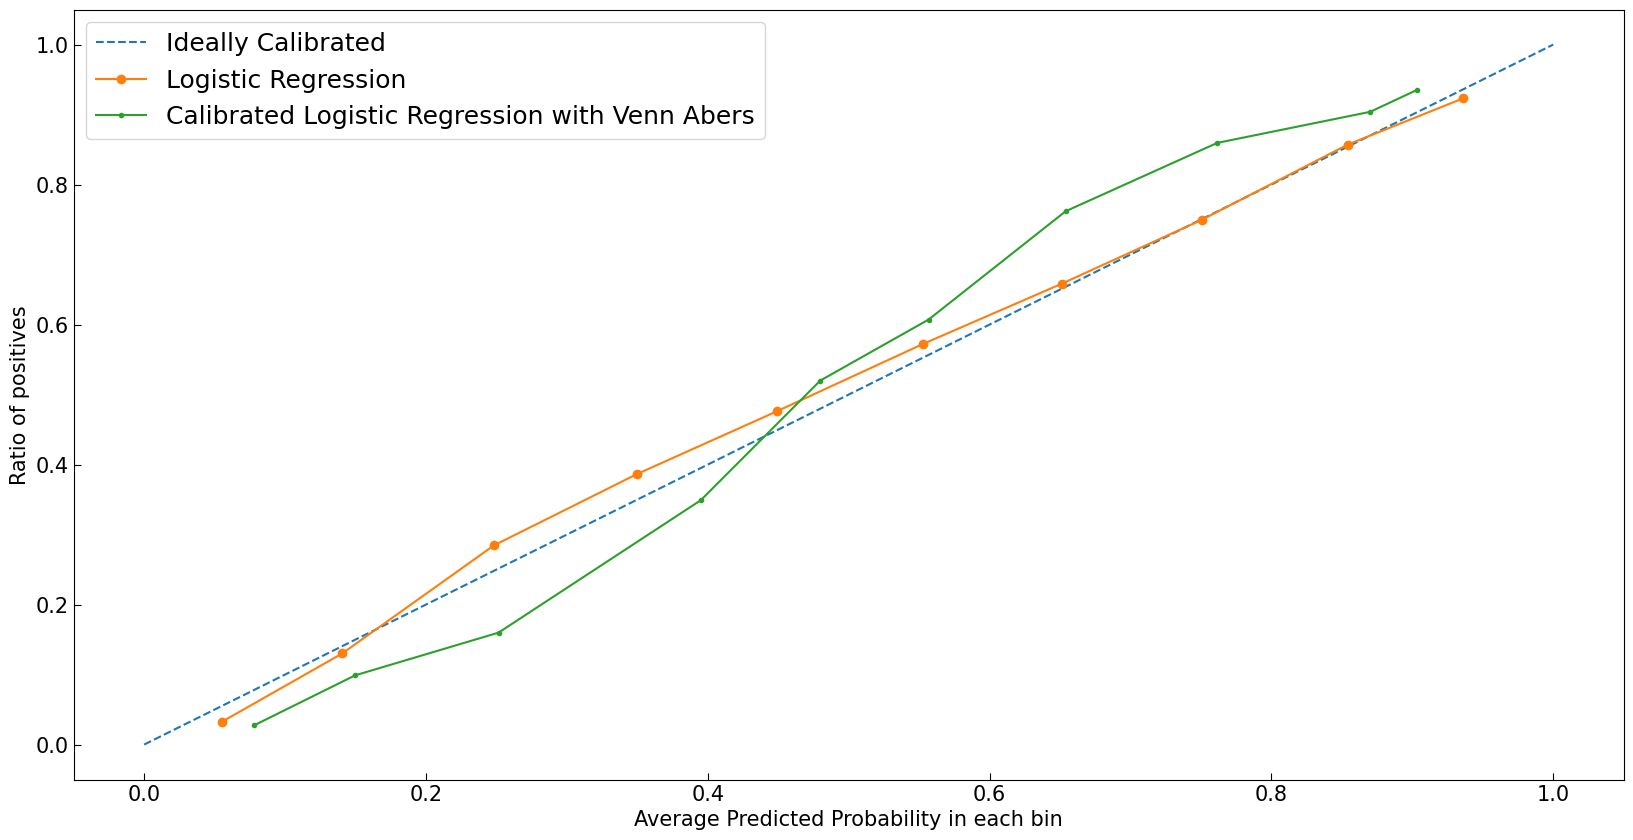

In [90]:
v_prob_true, v_prob_pred = calibration_curve(Y_test.values, dff["genuine"], n_bins=10)
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
plt.plot(prob_pred, prob_true, marker = 'o', label = 'Logistic Regression')
plt.plot(v_prob_pred, v_prob_true, marker = '.', label = 'Calibrated Logistic Regression with Venn Abers')

leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [38]:
import torch
from torch import nn
from collections import OrderedDict
import tensorflow as tf

2023-01-24 18:42:07.028249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Sequential(OrderedDict({
            'linear': nn.Linear(in_features=66, out_features=10),
            'relu': nn.ReLU(inplace=True),
        }))
        self.hidden_layer = nn.Linear(in_features=10, out_features=1)
        self.output_layer = nn.Sigmoid()
        self.losses = {}
        self.accuracies = {}
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        y_pred = self.output_layer(y)
        return y_pred
    
    def __initiate_loss_and_accuracy_dicts(self, n_epochs):
        for i in range(n_epochs):
            self.losses[i] = 0
            self.accuracies[i] = 0
    
    def fit(self, x_train, y_train, epochs, learning_rate, batch_size):
        self.__initiate_loss_and_accuracy_dicts(n_epochs=epochs)
        myDs=MyDataset(x_train=x_train, y_train=y_train)
        train_loader=torch.utils.data.DataLoader(myDs,batch_size=batch_size,shuffle=False)
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        for e in range(epochs):
            n_batches = len(train_loader)
            print(f'Epoch {e+1}/{epochs}')
            pbar = tf.keras.utils.Progbar(target=n_batches)
            for idx, batch in enumerate(train_loader):
                x, y = batch
                optimizer.zero_grad()
                outputs = self(x)
                loss = nn.BCELoss()
                loss_value = loss(outputs, y.reshape(-1, 1))
                loss_value.backward()
                optimizer.step()
                accuracy = accuracy_score(
                    y_true=y,
                    y_pred=outputs.reshape(-1).detach().numpy().round()
                )
                self.losses[e] += loss_value.detach().numpy()
                self.accuracies[e] += accuracy
                curr_idx = idx+1
                pbar.update(
                    idx,
                    values=[
                        ("loss", loss_value.detach().numpy()),
                        ("accuracy", accuracy)
                    ]
                )
            self.losses[e] = self.losses[e]/n_batches
            self.accuracies[e] = self.accuracies[e]/n_batches
            pbar.update(n_batches, values=None) 
            
    def predict_proba(self, x, as_numpy=False): 
        outputs = self(x)
        if as_numpy:
            outputs = outputs.detach().numpy()
        return outputs

In [40]:
class MyDataset(torch.utils.data.Dataset):
 
    def __init__(self, x_train, y_train):
        x=x_train.values
        y=y_train.values

        self.X_train=torch.tensor(x,dtype=torch.float32)
        self.Y_train=torch.tensor(y,dtype=torch.float32)

    def __len__(self):
        return len(self.Y_train)
   
    def __getitem__(self,idx):
        return self.X_train[idx],self.Y_train[idx]

In [92]:
model = Simple_Neural_Net()

epochs = 10
input_dim = 30 
output_dim = 1
learning_rate = 0.15

model.fit(x_train=X_train, y_train=Y_train, epochs=epochs, learning_rate=learning_rate, batch_size=10)

Epoch 1/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.5375
Epoch 2/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6145 - accuracy: 0.6687
Epoch 3/10
16/16 [==============================] - 0s 2ms/step - loss: 0.5105 - accuracy: 0.8000
Epoch 4/10
16/16 [==============================] - 0s 2ms/step - loss: 0.4173 - accuracy: 0.8375
Epoch 5/10
16/16 [==============================] - 0s 2ms/step - loss: 0.3616 - accuracy: 0.8500
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.3235 - accuracy: 0.8500
Epoch 7/10
16/16 [==============================] - 0s 2ms/step - loss: 0.2990 - accuracy: 0.8563
Epoch 8/10
16/16 [==============================] - 0s 2ms/step - loss: 0.2779 - accuracy: 0.8750
Epoch 9/10
16/16 [==============================] - 0s 2ms/step - loss: 0.2594 - accuracy: 0.8813
Epoch 10/10
16/16 [==============================] - 0s 2ms/step - loss: 0.2438 - accuracy: 0.8875


In [93]:
predictions = model.predict_proba(torch.from_numpy(X_calib.values.astype(np.float32)), as_numpy=True)

In [94]:
prob_true, prob_pred = calibration_curve(Y_calib.values, predictions, n_bins=10)

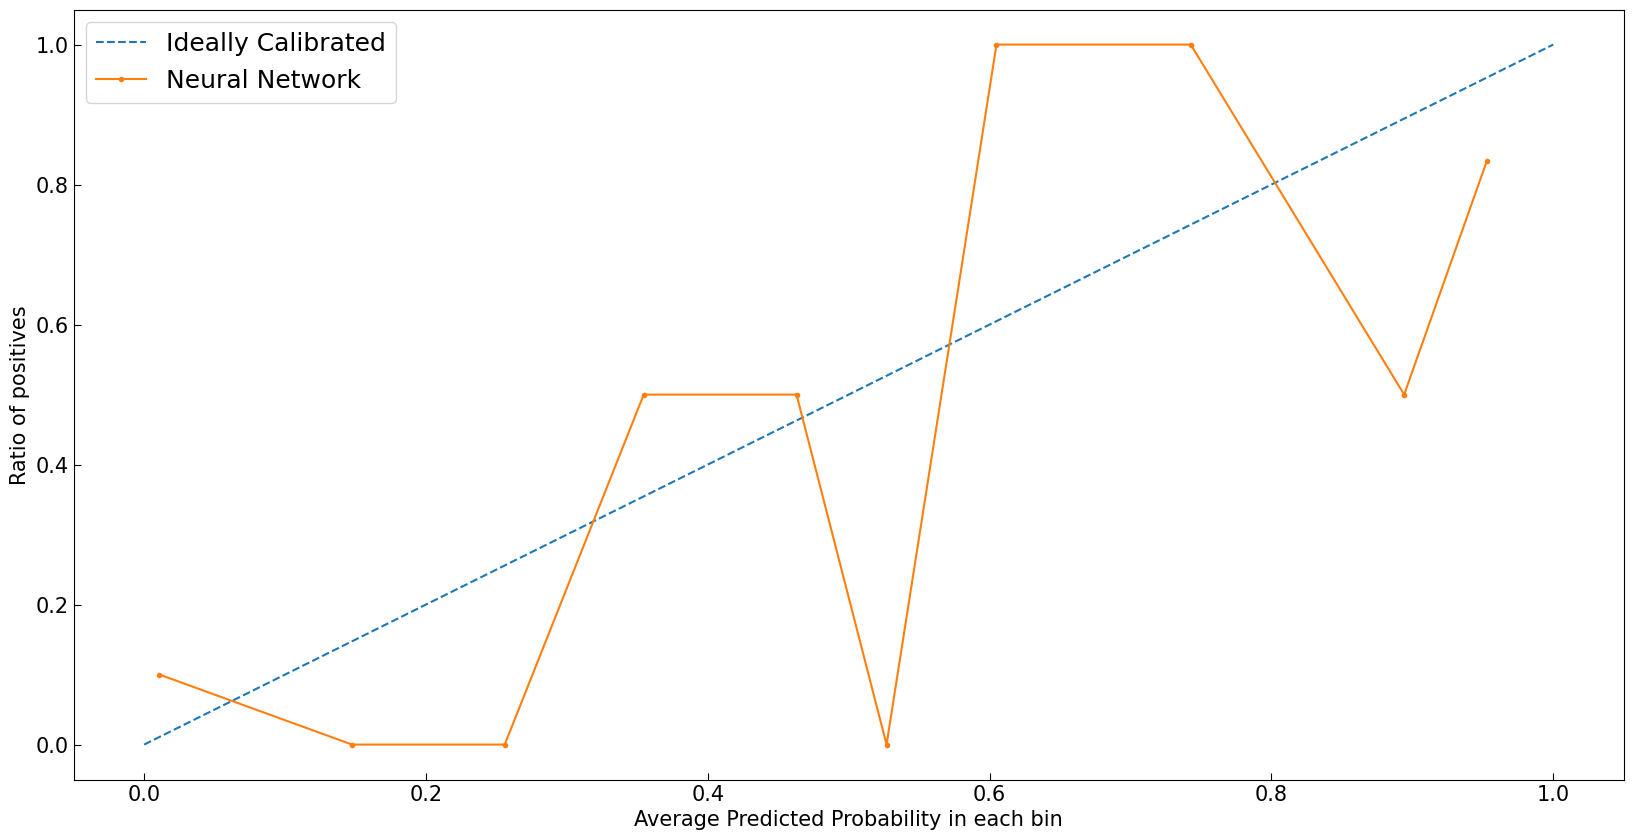

In [95]:
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve

plt.plot(prob_pred, prob_true, marker = '.', label = 'Neural Network')
 

leg = plt.legend(loc = 'upper left')

plt.xlabel('Average Predicted Probability in each bin')

plt.ylabel('Ratio of positives')
plt.show()


In [96]:
def venn_abers_pytorch(trained_classifier, calibration_features, test_instance, calibration_labels):
    calibrations = trained_classifier.predict_proba(calibration_features, as_numpy=True)
    predictions = trained_classifier.predict_proba(test_instance, as_numpy=True)
    interval = []
    scores = pd.DataFrame()
    scores["s"] = calibrations[:, 0]
    scores["y"] = calibration_labels.to_numpy()
    score = pd.DataFrame()
    score["s"] = predictions[:, 0]
    interval = []
    
    for i in [0, 1]:
        score["y"] = i
        train = pd.concat([scores, score], ignore_index=True)
        g = IsotonicRegression()
        g_scores = g.fit_transform(train["s"], train["y"])
        interval.append(np.round(g.predict(score["s"])[0], 3))
    return interval

In [97]:
venn_abers_pytorch(
    model,
    torch.from_numpy(X_calib.values.astype(np.float32)),
    torch.from_numpy(X_test[0:1].values.astype(np.float32)),
    Y_calib
)

[0.091, 0.333]

In [98]:
X_test_after = X_test.copy()
X_test_after["interval"] = X_test_after.apply(
    lambda x: venn_abers_pytorch(
        model,
        torch.from_numpy(X_calib.values.astype(np.float32)),
        torch.from_numpy(x.values.reshape(1, -1).astype(np.float32)),
        Y_calib)
    ,
    axis=1
)


In [99]:
X_test_after["proba"] = model.predict_proba(torch.from_numpy(X_test.values.astype(np.float32)), as_numpy=True)[:, 0]
X_test_after["Y"] = Y_test.copy()
dff = X_test_after[["Y", "interval", "proba"]].copy()

In [100]:
dff.head()

,Y,interval,proba
9111,1,"[0.091, 0.333]",0.235401
532,0,"[0.091, 0.5]",0.315960
6613,1,"[0.625, 0.75]",0.823577
5504,1,"[0.333, 0.75]",0.576560
2639,0,"[0.333, 0.75]",0.554396


In [101]:
dff["inf_prob"] = dff["interval"].apply(lambda x: x[0])
dff["sup_prob"] = dff["interval"].apply(lambda x: x[1])
dff["genuine"] = dff.apply(lambda x: x["sup_prob"]/(1-x["inf_prob"]+x["sup_prob"]), axis=1)
dff.head()

,Y,interval,proba,inf_prob,sup_prob,genuine
9111,1,"[0.091, 0.333]",0.235401,0.091,0.333,0.268116
532,0,"[0.091, 0.5]",0.315960,0.091,0.500,0.354862
6613,1,"[0.625, 0.75]",0.823577,0.625,0.750,0.666667
5504,1,"[0.333, 0.75]",0.576560,0.333,0.750,0.529287
2639,0,"[0.333, 0.75]",0.554396,0.333,0.750,0.529287


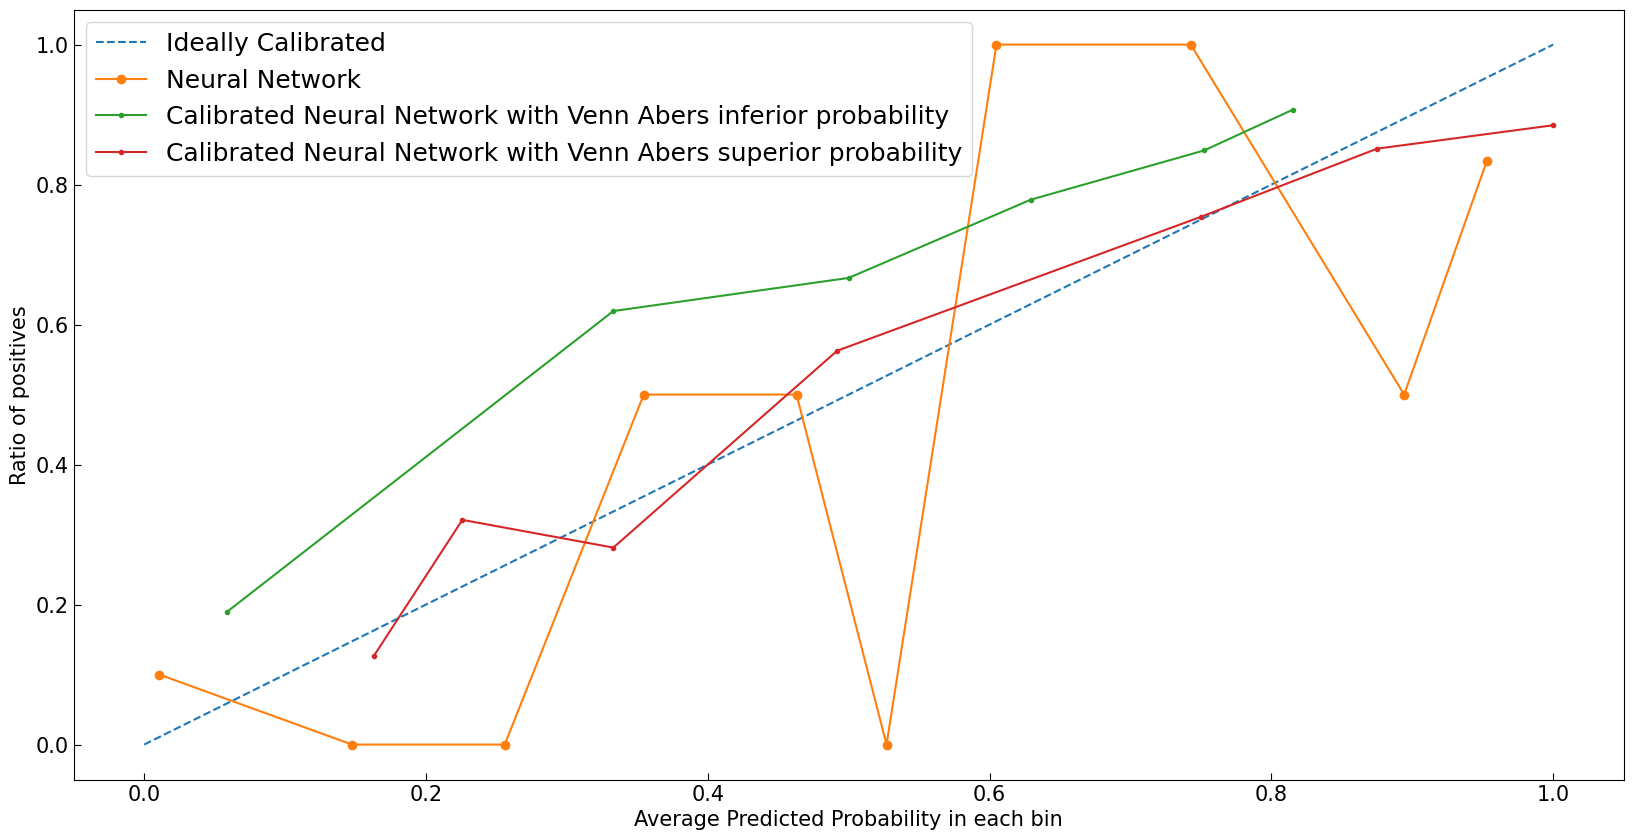

In [103]:
v_prob_true, v_prob_pred = calibration_curve(Y_test.values, dff["inf_prob"], n_bins=10)
v_prob_true2, v_prob_pred2 = calibration_curve(Y_test.values, dff["sup_prob"], n_bins=10)
plt.figure(figsize=(20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
plt.plot(prob_pred, prob_true, marker = 'o', label = 'Neural Network')
plt.plot(v_prob_pred, v_prob_true, marker = '.', label = 'Calibrated Neural Network with Venn Abers inferior probability')
plt.plot(v_prob_pred2, v_prob_true2, marker = '.', label = 'Calibrated Neural Network with Venn Abers superior probability')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()